In [248]:
# Imports
import os
import requests
import pandas as pd
import numpy as np
from pathlib import Path
from dotenv import load_dotenv
from datetime import datetime
from dateutil.relativedelta import *
import hvplot.pandas
import matplotlib.pyplot as plt
import holoviews as hv
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import yfinance as yf
from finta import TA
from transformers import pipeline
# To show a progress bar when doing lengthy operations
from tqdm.notebook import tqdm

In [249]:
# Establish constants and retrieve environment variables
ETF_FILE = './data/etf.csv'
NEWS_FILE = './data/news.csv'

# Retrieve alpaca credentials
load_dotenv()
alpaca_api_key = os.getenv('APCA-API-KEY-ID')
alpaca_secret_key = os.getenv('APCA-API-SECRET-KEY')
if not(alpaca_api_key) or not(alpaca_secret_key):
    print('Failed to load API credentials')

In [250]:
# Check if ETF data file exists, if so load the data from the file
# Otherwise retrieve the data from the yahoo finance API
etf_path = Path(ETF_FILE)
if etf_path.is_file():
    # etf_df = pd.read_csv(etf_path, index_col='Date', parse_dates=True, infer_datetime_format=True)
    etf_df = pd.read_csv(etf_path)
    print(etf_df.head())

In [251]:
# Get historical OHLCV data for target ticker if the data is not already stored in a csv
if not etf_path.is_file():
    etf_df = yf.download(
        "STW.AX, VAS.AX, SPY.AX", 
        period="max"
    )

[*********************100%***********************]  3 of 3 completed


In [252]:
# Retain the key columns for each etf
if not etf_path.is_file():
    # etf_df = etf_df.drop(columns = ['Adj Close', 'High', 'Low', 'Open', 'Volume'])
    # etf_df.columns = etf_df.columns.droplevel()     # Changes the multilevel indexing on columns to single level
    #  Drop all nulls
    etf_df = etf_df.dropna()
    # Save ETF data to file so that we don't have to download again when this notebook is rerun
    etf_df.to_csv(etf_path, index=False)


In [253]:
etf_df.head()

Adj Close                             Close             \
                SPY.AX     STW.AX     VAS.AX      SPY.AX     STW.AX   
Date                                                                  
2014-10-13  216.729996  48.599998  65.360001  216.729996  48.599998   
2014-10-14  213.949997  49.119999  66.059998  213.949997  49.119999   
2014-10-15  217.089996  49.500000  66.480003  217.089996  49.500000   
2014-10-16  212.434738  49.549999  66.599998  212.434738  49.549999   
2014-10-17  213.059998  49.779999  66.839996  213.059998  49.779999   

                             High                               Low  \
               VAS.AX      SPY.AX     STW.AX     VAS.AX      SPY.AX   
Date                                                                  
2014-10-13  65.360001  218.380005  48.700001  65.500000  216.199997   
2014-10-14  66.059998  214.660004  49.220001  66.160004  213.949997   
2014-10-15  66.480003  217.089996  49.529999  66.580002  216.630005   
2014-10-16  66.599998  212.434738  49.599998  66.669998  212.434738   
2014-10-17  66.839996  213.059998  50.060001  67.260002  212.419998   

                                        Open                        Volume  \
               STW.AX     VAS.AX      SPY.AX     STW.AX     VAS.AX  SPY.AX   
Date                                                                         
2014-10-13  48.200001  64.959999  218.149994  48.259998  65.110001  5140.0   
2014-10-14  48.320000  65.029999  214.000000  48.340000  65.260002  3320.0   
2014-10-15  49.029999  66.000000  216.630005  49.160000  66.059998  1230.0   
2014-10-16  48.700001  65.459999  212.434738  49.020000  66.019997     0.0   
2014-10-17  49.669998  66.730003  212.419998  49.730000  66.730003  1622.0   

                             
            STW.AX   VAS.AX  
Date                         
2014-10-13  177654  38801.0  
2014-10-14  136290  28254.0  
2014-10-15  164068  38596.0  
2014-10-16  333351  28965.0  
2014-10-17  112079  26288.0

# Technical indicators
## 1. Dual Moving Average Crossover

In [254]:
# Set the Window for shorter term and longer term moving average
short_window = 20
long_window = 200

## Generate entry / exit points for all 3 etf's
### Entry / exit point for SPY

In [255]:
etf_df.head()

Adj Close                             Close             \
                SPY.AX     STW.AX     VAS.AX      SPY.AX     STW.AX   
Date                                                                  
2014-10-13  216.729996  48.599998  65.360001  216.729996  48.599998   
2014-10-14  213.949997  49.119999  66.059998  213.949997  49.119999   
2014-10-15  217.089996  49.500000  66.480003  217.089996  49.500000   
2014-10-16  212.434738  49.549999  66.599998  212.434738  49.549999   
2014-10-17  213.059998  49.779999  66.839996  213.059998  49.779999   

                             High                               Low  \
               VAS.AX      SPY.AX     STW.AX     VAS.AX      SPY.AX   
Date                                                                  
2014-10-13  65.360001  218.380005  48.700001  65.500000  216.199997   
2014-10-14  66.059998  214.660004  49.220001  66.160004  213.949997   
2014-10-15  66.480003  217.089996  49.529999  66.580002  216.630005   
2014-10-16  66.599998  212.434738  49.599998  66.669998  212.434738   
2014-10-17  66.839996  213.059998  50.060001  67.260002  212.419998   

                                        Open                        Volume  \
               STW.AX     VAS.AX      SPY.AX     STW.AX     VAS.AX  SPY.AX   
Date                                                                         
2014-10-13  48.200001  64.959999  218.149994  48.259998  65.110001  5140.0   
2014-10-14  48.320000  65.029999  214.000000  48.340000  65.260002  3320.0   
2014-10-15  49.029999  66.000000  216.630005  49.160000  66.059998  1230.0   
2014-10-16  48.700001  65.459999  212.434738  49.020000  66.019997     0.0   
2014-10-17  49.669998  66.730003  212.419998  49.730000  66.730003  1622.0   

                             
            STW.AX   VAS.AX  
Date                         
2014-10-13  177654  38801.0  
2014-10-14  136290  28254.0  
2014-10-15  164068  38596.0  
2014-10-16  333351  28965.0  
2014-10-17  112079  26288.0

In [256]:
etf_new_df = etf_df.copy()

etf_new_df.columns = etf_new_df.columns.swaplevel()

etf_new_df = etf_new_df.dropna()

etf_new_df.head()

,SPY.AX,STW.AX,VAS.AX,SPY.AX,STW.AX,VAS.AX,SPY.AX,STW.AX,VAS.AX,SPY.AX,STW.AX,VAS.AX,SPY.AX,STW.AX,VAS.AX,SPY.AX,STW.AX,VAS.AX
,Adj Close,Adj Close,Adj Close,Close,Close,Close,High,High,High,Low,Low,Low,Open,Open,Open,Volume,Volume,Volume
Date,,,,,,,,,,,,,,,,,,
2014-10-13,216.729996,48.599998,65.360001,216.729996,48.599998,65.360001,218.380005,48.700001,65.500000,216.199997,48.200001,64.959999,218.149994,48.259998,65.110001,5140.0,177654,38801.0
2014-10-14,213.949997,49.119999,66.059998,213.949997,49.119999,66.059998,214.660004,49.220001,66.160004,213.949997,48.320000,65.029999,214.000000,48.340000,65.260002,3320.0,136290,28254.0
2014-10-15,217.089996,49.500000,66.480003,217.089996,49.500000,66.480003,217.089996,49.529999,66.580002,216.630005,49.029999,66.000000,216.630005,49.160000,66.059998,1230.0,164068,38596.0
2014-10-16,212.434738,49.549999,66.599998,212.434738,49.549999,66.599998,212.434738,49.599998,66.669998,212.434738,48.700001,65.459999,212.434738,49.020000,66.019997,0.0,333351,28965.0
2014-10-17,213.059998,49.779999,66.839996,213.059998,49.779999,66.839996,213.059998,50.060001,67.260002,212.419998,49.669998,66.730003,212.419998,49.730000,66.730003,1622.0,112079,26288.0


In [257]:
# Generate the fast and slow simple moving averages (20 and 200 days, respectively)

spy_etf_df = etf_new_df['SPY.AX']
spy_etf_df["Short"] = TA.SMA(spy_etf_df, short_window)
spy_etf_df["Long"] = TA.SMA(spy_etf_df, long_window)

spy_etf_df = spy_etf_df.dropna()

/home/gadam/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/gadam/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [258]:
# Geerate the entry / exit signals
spy_etf_df["Signal"] = 0.0

spy_etf_df["Signal"][short_window:] = np.where(
    spy_etf_df["Short"][short_window:] > spy_etf_df["Long"][short_window:], 1.0, 0.0
)

spy_etf_df["Entry/Exit"] = spy_etf_df["Signal"].diff()

spy_etf_df.head()

,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit
Date,,,,,,,,,,
2015-07-29,285.339996,285.339996,285.579987,285.339996,285.579987,363.0,282.070500,259.898916,0.0,NaN
2015-07-30,288.000000,288.000000,288.350006,287.739990,288.350006,173.0,282.899001,260.255266,0.0,0.0
2015-07-31,289.040009,289.040009,289.059998,289.010010,289.010010,384.0,283.670001,260.630716,0.0,0.0
2015-08-03,288.320007,288.320007,289.010010,288.320007,289.010010,198.0,284.383002,260.986866,0.0,0.0
2015-08-04,285.500000,285.500000,285.500000,285.500000,285.500000,30.0,284.766002,261.352193,0.0,0.0


In [259]:
# Visualize entry position relative to close price
spy_entry = spy_etf_df[spy_etf_df["Entry/Exit"] == 1.0]["Close"].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
spy_exit = spy_etf_df[spy_etf_df["Entry/Exit"] == -1.0]["Close"].hvplot.scatter(
    color='orange',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
spy_security_close = spy_etf_df[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
spy_moving_avgs = spy_etf_df[["Short", "Long"]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
spy_entry_exit_plot = spy_security_close * spy_moving_avgs * spy_entry * spy_exit
#hv.save(spy_entry_exit_plot, 'spy_entry_exit_plot.png',fmt='png')
#plt.savefig('/Users/vbn/Desktop/VenGitRepo/Project-2/fintech_project_2/spy_entry_exit_plot.png')
#plt.show()
spy_entry_exit_plot

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

# Entry / Exit points for STW

In [260]:
stw_etf_df = etf_new_df['STW.AX']
stw_etf_df["Short"] = TA.SMA(stw_etf_df, short_window)
stw_etf_df["Long"] = TA.SMA(stw_etf_df, long_window)

stw_etf_df = stw_etf_df.dropna()

/home/gadam/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/gadam/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [261]:
stw_etf_df["Signal"] = 0.0

stw_etf_df["Signal"][short_window:] = np.where(
    stw_etf_df["Short"][short_window:] > stw_etf_df["Long"][short_window:], 1.0, 0.0
)

stw_etf_df["Entry/Exit"] = stw_etf_df["Signal"].diff()

stw_etf_df.head()

/home/gadam/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit
Date,,,,,,,,,,
2015-07-29,52.520000,52.520000,52.750000,52.490002,52.700001,84266,52.0730,52.61950,0.0,NaN
2015-07-30,52.919998,52.919998,52.980000,52.720001,52.799999,74214,52.1060,52.64110,0.0,0.0
2015-07-31,53.160000,53.160000,53.209999,53.020000,53.020000,54302,52.1835,52.66130,0.0,0.0
2015-08-03,52.930000,52.930000,53.250000,52.910000,53.250000,36108,52.2760,52.67845,0.0,0.0
2015-08-04,53.150002,53.150002,53.480000,52.799999,52.950001,1688292,52.3310,52.69645,0.0,0.0


In [262]:
# Visualize entry position relative to close price
stw_entry = stw_etf_df[stw_etf_df["Entry/Exit"] == 1.0]["Close"].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
stw_exit = stw_etf_df[stw_etf_df["Entry/Exit"] == -1.0]["Close"].hvplot.scatter(
    color='orange',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
stw_security_close = stw_etf_df[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
stw_moving_avgs = stw_etf_df[["Short", "Long"]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
stw_entry_exit_plot = stw_security_close * stw_moving_avgs * stw_entry * stw_exit
stw_entry_exit_plot

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

# Entry / exit points for VAS

In [263]:
vas_etf_df = etf_new_df['VAS.AX']
vas_etf_df["Short"] = TA.SMA(vas_etf_df, short_window)
vas_etf_df["Long"] = TA.SMA(vas_etf_df, long_window)

vas_etf_df = vas_etf_df.dropna()

/home/gadam/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/gadam/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [264]:
vas_etf_df["Signal"] = 0.0

vas_etf_df["Signal"][short_window:] = np.where(
    vas_etf_df["Short"][short_window:] > vas_etf_df["Long"][short_window:], 1.0, 0.0
)

vas_etf_df["Entry/Exit"] = vas_etf_df["Signal"].diff()

vas_etf_df.head()

,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit
Date,,,,,,,,,,
2015-07-29,71.370003,71.370003,71.769997,71.250000,71.449997,30067.0,70.8450,71.27085,0.0,NaN
2015-07-30,71.959999,71.959999,71.959999,71.410004,71.410004,39040.0,70.8915,71.30385,0.0,0.0
2015-07-31,72.099998,72.099998,72.260002,72.000000,72.000000,36925.0,70.9855,71.33405,0.0,0.0
2015-08-03,71.949997,71.949997,72.489998,71.889999,72.489998,45618.0,71.1015,71.36140,0.0,0.0
2015-08-04,72.269997,72.269997,72.599998,71.849998,72.010002,64205.0,71.1755,71.38975,0.0,0.0


In [265]:
# Visualize entry position relative to close price
vas_entry = vas_etf_df[vas_etf_df["Entry/Exit"] == 1.0]["Close"].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
vas_exit = vas_etf_df[vas_etf_df["Entry/Exit"] == -1.0]["Close"].hvplot.scatter(
    color='orange',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
vas_security_close = vas_etf_df[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
vas_moving_avgs = vas_etf_df[["Short", "Long"]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
vas_entry_exit_plot = vas_security_close * vas_moving_avgs * vas_entry * vas_exit
vas_entry_exit_plot

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

# Using bolinger bands for entry / exit signals

In [266]:


# Bolinger Band signals for SPY

spy_bb_signals_df = spy_etf_df.copy()
spy_bb_signals_df.head()



,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit
Date,,,,,,,,,,
2015-07-29,285.339996,285.339996,285.579987,285.339996,285.579987,363.0,282.070500,259.898916,0.0,NaN
2015-07-30,288.000000,288.000000,288.350006,287.739990,288.350006,173.0,282.899001,260.255266,0.0,0.0
2015-07-31,289.040009,289.040009,289.059998,289.010010,289.010010,384.0,283.670001,260.630716,0.0,0.0
2015-08-03,288.320007,288.320007,289.010010,288.320007,289.010010,198.0,284.383002,260.986866,0.0,0.0
2015-08-04,285.500000,285.500000,285.500000,285.500000,285.500000,30.0,284.766002,261.352193,0.0,0.0


In [267]:
# Determine the Bollinger Bands for the Dataset
spy_bbands_df = TA.BBANDS(spy_bb_signals_df)

# Review the DataFrame

spy_bbands_df = spy_bbands_df.dropna()
spy_bbands_df.head()

,BB_UPPER,BB_MIDDLE,BB_LOWER
Date,,,
2015-08-25,295.791124,283.294333,270.797542
2015-08-26,297.477418,282.197833,266.918249
2015-08-27,296.923052,281.514833,266.106614
2015-08-28,296.020579,280.941832,265.863085
2015-08-31,295.136009,280.390332,265.644655


In [268]:
# Concatenate the Bollinger Bands to the DataFrame
spy_bb_signals_df = pd.concat([spy_bb_signals_df, spy_bbands_df], axis=1)
spy_bb_signals_df.head()

,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit,BB_UPPER,BB_MIDDLE,BB_LOWER
Date,,,,,,,,,,,,,
2015-07-29,285.339996,285.339996,285.579987,285.339996,285.579987,363.0,282.070500,259.898916,0.0,NaN,NaN,NaN,NaN
2015-07-30,288.000000,288.000000,288.350006,287.739990,288.350006,173.0,282.899001,260.255266,0.0,0.0,NaN,NaN,NaN
2015-07-31,289.040009,289.040009,289.059998,289.010010,289.010010,384.0,283.670001,260.630716,0.0,0.0,NaN,NaN,NaN
2015-08-03,288.320007,288.320007,289.010010,288.320007,289.010010,198.0,284.383002,260.986866,0.0,0.0,NaN,NaN,NaN
2015-08-04,285.500000,285.500000,285.500000,285.500000,285.500000,30.0,284.766002,261.352193,0.0,0.0,NaN,NaN,NaN


In [269]:
# Visualize close price for the investment
spy_sec_close = spy_bb_signals_df[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

spy_bb_upper = spy_bb_signals_df[["BB_UPPER"]].hvplot(
    line_color='purple',
    ylabel='Price in $',
    width=1000,
    height=400
)


spy_bb_middle = spy_bb_signals_df[["BB_MIDDLE"]].hvplot(
    line_color='orange',
    ylabel='Price in $',
    width=1000,
    height=400
)

spy_bb_lower = spy_bb_signals_df[["BB_LOWER"]].hvplot(
    line_color='blue',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
spy_bbands_plot = spy_sec_close * spy_bb_upper * spy_bb_middle * spy_bb_lower * spy_entry * spy_exit
spy_bbands_plot

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Curve.II         :Curve   [Date]   (BB_UPPER)
   .Curve.III        :Curve   [Date]   (BB_MIDDLE)
   .Curve.IV         :Curve   [Date]   (BB_LOWER)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [270]:
# Bolinger Band signals for STW

stw_bb_signals_df = stw_etf_df.copy()
stw_bb_signals_df.head()

,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit
Date,,,,,,,,,,
2015-07-29,52.520000,52.520000,52.750000,52.490002,52.700001,84266,52.0730,52.61950,0.0,NaN
2015-07-30,52.919998,52.919998,52.980000,52.720001,52.799999,74214,52.1060,52.64110,0.0,0.0
2015-07-31,53.160000,53.160000,53.209999,53.020000,53.020000,54302,52.1835,52.66130,0.0,0.0
2015-08-03,52.930000,52.930000,53.250000,52.910000,53.250000,36108,52.2760,52.67845,0.0,0.0
2015-08-04,53.150002,53.150002,53.480000,52.799999,52.950001,1688292,52.3310,52.69645,0.0,0.0


In [271]:
# Determine the Bollinger Bands for the Dataset
stw_bbands_df = TA.BBANDS(stw_bb_signals_df)

# Review the DataFrame

stw_bbands_df = stw_bbands_df.dropna()
stw_bbands_df.head()

,BB_UPPER,BB_MIDDLE,BB_LOWER
Date,,,
2015-08-25,54.434940,50.8880,47.341060
2015-08-26,54.292056,50.6920,47.091944
2015-08-27,54.002467,50.5095,47.016532
2015-08-28,53.612133,50.3265,47.040867
2015-08-31,53.224824,50.1295,47.034176


In [272]:
# Concatenate the Bollinger Bands to the DataFrame

stw_bb_signals_df = pd.concat([stw_bb_signals_df, stw_bbands_df], axis=1)
stw_bb_signals_df.head()

,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit,BB_UPPER,BB_MIDDLE,BB_LOWER
Date,,,,,,,,,,,,,
2015-07-29,52.520000,52.520000,52.750000,52.490002,52.700001,84266,52.0730,52.61950,0.0,NaN,NaN,NaN,NaN
2015-07-30,52.919998,52.919998,52.980000,52.720001,52.799999,74214,52.1060,52.64110,0.0,0.0,NaN,NaN,NaN
2015-07-31,53.160000,53.160000,53.209999,53.020000,53.020000,54302,52.1835,52.66130,0.0,0.0,NaN,NaN,NaN
2015-08-03,52.930000,52.930000,53.250000,52.910000,53.250000,36108,52.2760,52.67845,0.0,0.0,NaN,NaN,NaN
2015-08-04,53.150002,53.150002,53.480000,52.799999,52.950001,1688292,52.3310,52.69645,0.0,0.0,NaN,NaN,NaN


In [273]:
# Visualize close price for the investment
stw_sec_close = stw_bb_signals_df[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

stw_bb_upper = stw_bb_signals_df[["BB_UPPER"]].hvplot(
    line_color='purple',
    ylabel='Price in $',
    width=1000,
    height=400
)

stw_bb_middle = stw_bb_signals_df[["BB_MIDDLE"]].hvplot(
    line_color='orange',
    ylabel='Price in $',
    width=1000,
    height=400
)

stw_bb_lower = stw_bb_signals_df[["BB_LOWER"]].hvplot(
    line_color='blue',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
stw_bbands_plot = stw_sec_close * stw_bb_upper * stw_bb_middle * stw_bb_lower * stw_entry * stw_exit
stw_bbands_plot

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Curve.II         :Curve   [Date]   (BB_UPPER)
   .Curve.III        :Curve   [Date]   (BB_MIDDLE)
   .Curve.IV         :Curve   [Date]   (BB_LOWER)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [274]:
# Bolinger Band signals for VAS

vas_bb_signals_df = vas_etf_df.copy()
vas_bb_signals_df.head()

,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit
Date,,,,,,,,,,
2015-07-29,71.370003,71.370003,71.769997,71.250000,71.449997,30067.0,70.8450,71.27085,0.0,NaN
2015-07-30,71.959999,71.959999,71.959999,71.410004,71.410004,39040.0,70.8915,71.30385,0.0,0.0
2015-07-31,72.099998,72.099998,72.260002,72.000000,72.000000,36925.0,70.9855,71.33405,0.0,0.0
2015-08-03,71.949997,71.949997,72.489998,71.889999,72.489998,45618.0,71.1015,71.36140,0.0,0.0
2015-08-04,72.269997,72.269997,72.599998,71.849998,72.010002,64205.0,71.1755,71.38975,0.0,0.0


# Natural language processing
## This section will attempt to determine sentiment analysis from news headlines
### Approach
1. For each ETF, find the top 10 tickers by market cap
2. Retrieve the news headline for each ticker for each day in the dataset
3. Convert each headline to a sentiment indicating `negative`, `neutral` or `positive` using:
  3.1. distilRoberta-financial-sentiment
  3.2. This model is a fine-tuned version of `distilroberta-base` on the `financial_phrasebank` dataset. It achieves the following results on the evaluation set:
  3.3.    Loss: 0.1116
  3.4.    Accuracy: 0.9823
4. If there are multiple headlines for a day, retain the most frequent sentiment

In [275]:
# Collect the top 10 stocks of the Vangard to use as proxy for the SPY.AX ETF
# Note - hardcoding the stocks as there does not appear to be an easier way to 
# programitcally retrieve the constituent stocks
spy_top10 = [
    {
        'symbol': 'AAPL',
        'description': 'Apple'
    }, 
    {
        'symbol': 'MSFT',
        'description': 'Microsoft' 
    },
    {
        'symbol': 'AMZN',
        'description': 'Amazon' 
    },
    {
        'symbol': 'TSLA',
        'description': 'Tesla' 
    },
    {
        'symbol': 'GOOGL',
        'description': 'Google'  
    },
    {
        'symbol': 'GOOG', 
        'description': 'Google'
    },
    {
        'symbol': 'NVDA', 
        'description': 'Nvidia'
    },
    {
        'symbol': 'BRK.B', 
        'description': 'Berkshire'
    },
    {
        'symbol': 'META', 
        'description': 'Meta'
    },
    {
        'symbol': 'UNH',
        'description': 'United Health'
    }
]

In [276]:
# Collect the top 10 stocks of the Vanguard fund to use as proxy for the VAS.AX ETF
# Note - hardcoding the stocks as there does not appear to be an easier way to 
# programitcally retrieve the vanguarg constituent stocks
vas_top10 = [
    {
        'symbol': 'BHP',
        'description': 'BHP'
    }, 
    {
        'symbol': 'CBA',
        'description': 'Commonwealth Bank' 
    },
    {
        'symbol': 'CSL',
        'description': 'CSL' 
    },
    {
        'symbol': 'NAB',
        'description': 'NAB' 
    },
    {
        'symbol': 'NAB',
        'description': 'National Australia Bank'
    },
    {
        'symbol': 'WBC',
        'description': 'Westpac'  
    },
    {
        'symbol': 'ANZDA', 
        'description': 'ANZ Bank'
    },
    {
        'symbol': 'WDS', 
        'description': 'Woodside'
    },
    {
        'symbol': 'MQG', 
        'description': 'Macquarie Group'
    },
    {
        'symbol': 'WES', 
        'description': 'Wesfarmers'
    },
    {
        'symbol': 'TLS',
        'description': 'Telstra'
    }
]

In [277]:
# Collect the top 10 stocks of the ASX 200 to use as proxy for the STW.AX ETF
# Note - hardcoding the stocks as there does not appear to be an easier way to 
# programitcally retrieve the constituent stocks
stw_top10 = [
    {
        'symbol': 'BHP',
        'description': 'BHP'
    }, 
    {
        'symbol': 'CBA',
        'description': 'Commonwealth Bank' 
    },
    {
        'symbol': 'CSL',
        'description': 'CSL' 
    },
    {
        'symbol': 'NAB',
        'description': 'NAB' 
    },
    {
        'symbol': 'NAB',
        'description': 'National Australia Bank'
    },
    {
        'symbol': 'WBC',
        'description': 'Westpac'  
    },
    {
        'symbol': 'ANZDA', 
        'description': 'ANZ Bank'
    },
    {
        'symbol': 'WDS', 
        'description': 'Woodside'
    },
    {
        'symbol': 'MQG', 
        'description': 'Macquarie Group'
    },
    {
        'symbol': 'WES', 
        'description': 'Wesfarmers'
    },
    {
        'symbol': 'TLS',
        'description': 'Telstra'
    }
]

In [278]:
# Check to see if we already have some data on disk
news_path = Path(NEWS_FILE)
news_path.is_file()

True

In [279]:
def retrieve_news():

    # Create an empty dataframe to receive the news
    buzz_df = pd.DataFrame()

    # Prepare to retrieve news from alpaca
    alpaca_endpoint = 'https://data.alpaca.markets/v1beta1/news'

    alpaca_headers = {
        'Apca-Api-Key-Id': alpaca_api_key,
        'Apca-Api-Secret-Key': alpaca_secret_key
    }
    
    parameters = {
        'symbols': spy_top10[0]['symbol'],
        'start': pd.to_datetime(etf_df.index[0]).strftime('%Y-%m-%d'),
        'end': pd.to_datetime(etf_df.index[-1]).strftime('%Y-%m-%d'),
        'limit': 50,
        'include_content': False,
    }

    response = requests.get(
        url = alpaca_endpoint,
        headers = alpaca_headers,
        params = parameters
    )

    response.raise_for_status()

    # Unpack the news from response
    news_page = pd.DataFrame(response.json()['news'])

    # Create a news dataframe
    # news_df = news_page.loc[news_page['headline'].str.contains(spy_top10[0]['description'], na=False, case=False)]
    buzz_df = buzz_df.append(news_page, ignore_index=True)

    # Loop through all the remaining news data
    while(response.json()['next_page_token'] != None):
        parameters['page_token'] = response.json()['next_page_token']

        response = requests.get(
            url = alpaca_endpoint,
            headers = alpaca_headers,
            params = parameters
        )

        response.raise_for_status()

        news_page = pd.DataFrame(response.json()['news'])
        # print(f"{news_page.iloc[-1]['headline']}")
        buzz_df = buzz_df.append(news_page, ignore_index=True)
    
    # Save data to csv as downloading from alpaca can take up to 10 minutes
    buzz_df.to_csv(Path('./data/news.csv'), index=False)

    # And return the dataframe to the caller
    return buzz_df

In [280]:
# Get the news for the historical period from file or from alpaca news API
news_df = pd.DataFrame()
if news_path.is_file():
    news_df = pd.read_csv(news_path)
else:
    news_df = retrieve_news()


In [281]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21503 entries, 0 to 21502
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   author      21503 non-null  object 
 1   content     0 non-null      float64
 2   created_at  21503 non-null  object 
 3   headline    21503 non-null  object 
 4   id          21503 non-null  int64  
 5   images      21503 non-null  object 
 6   source      4250 non-null   object 
 7   summary     6226 non-null   object 
 8   symbols     21503 non-null  object 
 9   updated_at  21503 non-null  object 
 10  url         21503 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 1.8+ MB


In [282]:
# Cast `news_df` column types to proper data types so that future df merges will work
news_df = news_df.astype(
    {
        'author': 'string',
        'content': 'string',
        'created_at': 'string',
        'headline': 'string',
        'images': 'string',
        'source': 'string',
        'symbols': 'string',
        'summary': 'string',
        'updated_at': 'string',
        'url': 'string'
    }
)
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21503 entries, 0 to 21502
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   author      21503 non-null  string
 1   content     0 non-null      string
 2   created_at  21503 non-null  string
 3   headline    21503 non-null  string
 4   id          21503 non-null  int64 
 5   images      21503 non-null  string
 6   source      4250 non-null   string
 7   summary     6226 non-null   string
 8   symbols     21503 non-null  string
 9   updated_at  21503 non-null  string
 10  url         21503 non-null  string
dtypes: int64(1), string(10)
memory usage: 1.8 MB


In [283]:
len(news_df)

21503

In [284]:
# Instantiate a sentiment analysis pipleline based on the `Transformers` model
# etf_pipeline = pipeline('sentiment-analysis')

In [285]:
etf_pipeline = pipeline(model='mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis')

In [286]:
# Filter on news related to SPY stocks
spy_df = pd.DataFrame(columns=news_df.columns)
for i in range(len(spy_top10)):
    subset_df = news_df.loc[
        news_df['headline'].str.contains(spy_top10[i]['description'], na=False, case=False)
    ]
    spy_df = pd.merge(spy_df, subset_df, how='outer')


In [287]:
# Add new column for SPY sentiment
spy_df['SPY_Sentiment'] = np.NaN


In [288]:
# Using the `Transformers` model, add a sentiment flag for each headline
for i, row in tqdm(spy_df.iterrows(), total=len(spy_df)):
    sentiment = etf_pipeline(row['headline'])
    if sentiment[0]['label'] == 'negative':
        sentiment_flag = -1.0
    elif sentiment[0]['label'] == 'positive':
        sentiment_flag = 1.0
    else:
        sentiment_flag = 0.0
    spy_df._set_value(i, 'SPY_Sentiment', sentiment_flag) 

  0%|          | 0/13885 [00:00<?, ?it/s]

In [289]:
spy_df.iloc[10].headline

'Apple Currently Has No Plans To Re-Introduce The iPhone 15 mini In 2023'

In [290]:
etf_pipeline(spy_df.iloc[10].headline)

[{'label': 'neutral', 'score': 0.9998736381530762}]

In [308]:
spy_df.head()

,author,content,created_at,headline,id,images,source,summary,symbols,updated_at,url,SPY_Sentiment
updated_at,,,,,,,,,,,,
2015-01-02 14:09:15+00:00,Benzinga,<NA>,2015-01-02T14:09:15Z,Argus Expects Apple To Report Strong Q1 Result...,5115376,[],<NA>,<NA>,['AAPL'],2015-01-02T14:09:15Z,https://www.benzinga.com/node/5115376,1.0
2015-01-02 15:12:32+00:00,Benzinga,<NA>,2015-01-02T15:12:32Z,Hearing Chatter of Overheating in Apple iPhone 6,5115611,[],<NA>,<NA>,['AAPL'],2015-01-02T15:12:32Z,https://www.benzinga.com/node/5115611,0.0
2015-01-02 15:57:04+00:00,Benzinga,<NA>,2015-01-02T15:33:04Z,Study: Only Five Percent of U.S. iPhone Users ...,5115509,[],<NA>,<NA>,['AAPL'],2015-01-02T15:57:04Z,https://www.benzinga.com/node/5115509,0.0
2015-01-03 15:08:07+00:00,Benzinga,<NA>,2015-01-03T15:08:07Z,European Apple Sites Now Show Watch 'Available...,5116744,[],<NA>,<NA>,['AAPL'],2015-01-03T15:08:07Z,https://www.benzinga.com/node/5116744,0.0
2015-01-03 20:28:16+00:00,Benzinga,<NA>,2015-01-03T20:28:16Z,"Weekly Highlights: Apple Pay Growth, Apple Wat...",5116132,[],<NA>,<NA>,"['AAPL', 'AOL', 'YHOO']",2015-01-03T20:28:16Z,https://www.benzinga.com/node/5116132,1.0


In [292]:
# Filter on news related to ASX-200 stocks
stw_df = pd.DataFrame(columns=news_df.columns)
for i in range(len(stw_top10)):
    subset_df = news_df.loc[

        news_df['headline'].str.contains(stw_top10[i]['description'], na=False, case=False)
    ]
    stw_df = pd.merge(stw_df, subset_df, how='outer')

stw_df.shape

(104, 11)

In [293]:
# Add new column for STW sentiment
stw_df['STW_Sentiment'] = np.NaN

In [294]:
# Using the `Transformers` model, add a sentiment flag for each headline
for i, row in tqdm(stw_df.iterrows(), total=len(stw_df)):
    sentiment = etf_pipeline(row['headline'])
    if sentiment[0]['label'] == 'NEGATIVE':
        sentiment_flag = -1.0
    elif sentiment[0]['label'] == 'POSITIVE':
        sentiment_flag = 1.0
    else:
        sentiment_flag = 0.0
    stw_df._set_value(i, 'STW_Sentiment', sentiment_flag) 

  0%|          | 0/104 [00:00<?, ?it/s]

In [295]:
stw_df.head()

,author,content,created_at,headline,id,images,source,summary,symbols,updated_at,url,STW_Sentiment
0,Benzinga,<NA>,2018-02-22T16:49:39Z,"Cobalt Stocks Continue Higher Thurs., Potentia...",11243568,[],<NA>,<NA>,"['AAPL', 'BHP', 'FCX', 'VALE']",2018-02-22T16:49:39Z,https://www.benzinga.com/node/11243568,0.0
1,Vandana Singh,<NA>,2022-12-28T13:02:16Z,"China Relaxes Approval Of Imported Games, Goog...",30212156,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,Reuters,"['AAPL', 'AMZN', 'BA', 'BABA', 'BNBUSD', 'BTCU...",2022-12-28T13:02:16Z,https://www.benzinga.com/news/large-cap/22/12/...,0.0
2,Shivdeep Dhaliwal,<NA>,2022-12-01T01:48:47Z,"After Elon Musk's Tirade, Mark Zuckerberg Slam...",29916750,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,Meta Platforms Inc (NASDAQ: META) CEO Mark Zuc...,"['AAPL', 'GOOG', 'GOOGL', 'META']",2022-12-01T01:48:47Z,https://www.benzinga.com/news/22/11/29916750/a...,0.0
3,Maureen Meehan,<NA>,2022-11-25T20:09:12Z,Louis Armstrong Loved Cannabis And Didn't Care...,29844467,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,When Jazz legend and New Orleans native Louis ...,['AAPL'],2022-11-25T20:09:12Z,https://www.benzinga.com/markets/cannabis/22/1...,0.0
4,Benzinga Newsdesk,<NA>,2022-11-10T13:08:52Z,"Apple Says With Upgraded Ground Stations, Soon...",29657047,[],benzinga,<NA>,"['AAPL', 'GSAT']",2022-11-10T13:08:52Z,https://www.benzinga.com/news/22/11/29657047/a...,0.0


In [296]:
# Filter on news related to the Vanguard ETF stocks
vas_df = pd.DataFrame(columns=news_df.columns)
for i in range(len(vas_top10)):
    subset_df = news_df.loc[
        news_df['headline'].str.contains(vas_top10[i]['description'], na=False, case=False)
    ]
    vas_df = pd.merge(vas_df, subset_df, how='outer')

vas_df.shape

(104, 11)

In [297]:
# Add new column for VAS sentiment
vas_df['VAS_Sentiment'] = np.NaN

In [298]:
# Using the `Transformers` model, add a sentiment flag for each headline
for i, row in tqdm(vas_df.iterrows(), total=len(vas_df)):
    sentiment = etf_pipeline(row['headline'])
    if sentiment[0]['label'] == 'NEGATIVE':
        sentiment_flag = -1.0
    elif sentiment[0]['label'] == 'POSITIVE':
        sentiment_flag = 1.0
    else:
        sentiment_flag = 0.0
    vas_df._set_value(i, 'VAS_Sentiment', sentiment_flag) 

  0%|          | 0/104 [00:00<?, ?it/s]

In [299]:
vas_df.head()

,author,content,created_at,headline,id,images,source,summary,symbols,updated_at,url,VAS_Sentiment
0,Benzinga,<NA>,2018-02-22T16:49:39Z,"Cobalt Stocks Continue Higher Thurs., Potentia...",11243568,[],<NA>,<NA>,"['AAPL', 'BHP', 'FCX', 'VALE']",2018-02-22T16:49:39Z,https://www.benzinga.com/node/11243568,0.0
1,Vandana Singh,<NA>,2022-12-28T13:02:16Z,"China Relaxes Approval Of Imported Games, Goog...",30212156,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,Reuters,"['AAPL', 'AMZN', 'BA', 'BABA', 'BNBUSD', 'BTCU...",2022-12-28T13:02:16Z,https://www.benzinga.com/news/large-cap/22/12/...,0.0
2,Shivdeep Dhaliwal,<NA>,2022-12-01T01:48:47Z,"After Elon Musk's Tirade, Mark Zuckerberg Slam...",29916750,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,Meta Platforms Inc (NASDAQ: META) CEO Mark Zuc...,"['AAPL', 'GOOG', 'GOOGL', 'META']",2022-12-01T01:48:47Z,https://www.benzinga.com/news/22/11/29916750/a...,0.0
3,Maureen Meehan,<NA>,2022-11-25T20:09:12Z,Louis Armstrong Loved Cannabis And Didn't Care...,29844467,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,When Jazz legend and New Orleans native Louis ...,['AAPL'],2022-11-25T20:09:12Z,https://www.benzinga.com/markets/cannabis/22/1...,0.0
4,Benzinga Newsdesk,<NA>,2022-11-10T13:08:52Z,"Apple Says With Upgraded Ground Stations, Soon...",29657047,[],benzinga,<NA>,"['AAPL', 'GSAT']",2022-11-10T13:08:52Z,https://www.benzinga.com/news/22/11/29657047/a...,0.0


## Since only limited news data could be found for STW and VAS ETF companies, we will focus on the S&P 500 ETF instead

In [309]:
# Focusing on the S&P 500, use the `updated_at` column as index
spy_df.index = pd.to_datetime(spy_df['updated_at'])

In [310]:
# find the most frequent sentiment per day
spy_df.sort_index(inplace=True)
spy_sentiment = spy_df.groupby(spy_df.index.date)['SPY_Sentiment'] \
    .apply(lambda x: x.value_counts().sort_values(ascending=False).head(1)) \
    .to_frame()

In [311]:
spy_sentiment.reset_index(level=1, inplace=True)
spy_sentiment

,level_1,SPY_Sentiment
2015-01-02,0.0,2
2015-01-03,0.0,2
2015-01-05,0.0,1
2015-01-06,0.0,2
2015-01-07,-1.0,1
...,...,...
2022-12-28,0.0,5
2022-12-29,0.0,4
2022-12-30,0.0,3
2023-01-01,0.0,1


In [312]:
spy_sentiment = spy_sentiment.rename(columns={'SPY_Sentiment': 'Sentiment_Frequency'})
spy_sentiment = spy_sentiment.rename(columns={'level_1': 'SPY_Sentiment'})
print(spy_sentiment)

            SPY_Sentiment  Sentiment_Frequency
2015-01-02            0.0                    2
2015-01-03            0.0                    2
2015-01-05            0.0                    1
2015-01-06            0.0                    2
2015-01-07           -1.0                    1
...                   ...                  ...
2022-12-28            0.0                    5
2022-12-29            0.0                    4
2022-12-30            0.0                    3
2023-01-01            0.0                    1
2023-01-03            0.0                    5

[2360 rows x 2 columns]


<AxesSubplot:>

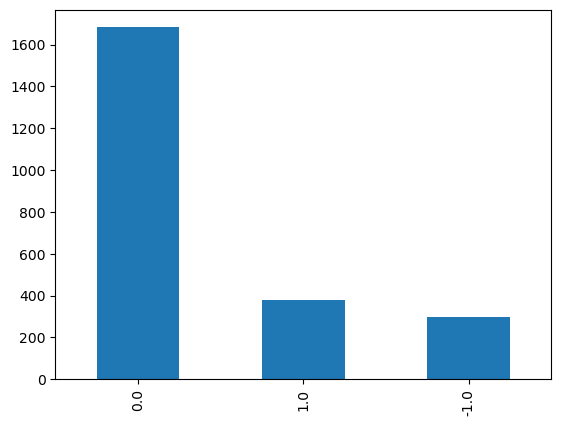

In [313]:
spy_sentiment['SPY_Sentiment'].value_counts().plot(kind='bar')

In [329]:
# Merge sentiment and ETF values
ETF_Sentiment = pd.concat([spy_etf_df, spy_sentiment], axis=1)
ETF_Sentiment.tail()

,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit,SPY_Sentiment,Sentiment_Frequency
2023-01-04,560.500000,560.500000,567.000000,560.500000,564.950012,90.0,577.174997,580.98080,0.0,0.0,NaN,NaN
2023-01-05,563.140015,563.140015,563.140015,561.000000,561.830017,127.0,575.597998,580.80150,0.0,0.0,NaN,NaN
2023-01-06,563.669983,563.669983,563.750000,561.669983,563.030029,696.0,574.045996,580.62335,0.0,0.0,NaN,NaN
2023-01-09,562.090027,562.090027,565.000000,561.210022,564.200012,220.0,572.673499,580.41950,0.0,0.0,NaN,NaN
2023-01-10,560.419983,560.419983,561.840027,559.500000,561.630005,147.0,571.423999,580.25065,0.0,0.0,NaN,NaN


In [330]:
# Remove nulls for potential days where news not available
ETF_Sentiment = ETF_Sentiment.dropna()

# Mask the `SPY_Sentiment`values for rows that don't have entry/exit signals
# ETF_Sentiment['SPY_Sentiment'] = np.where(ETF_Sentiment['Signal'] != 0.0, ETF_Sentiment['SPY_Sentiment'], np.NaN)
ETF_Sentiment.head()

,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit,SPY_Sentiment,Sentiment_Frequency
2015-07-30,288.000000,288.000000,288.350006,287.739990,288.350006,173.0,282.899001,260.255266,0.0,0.0,0.0,1.0
2015-07-31,289.040009,289.040009,289.059998,289.010010,289.010010,384.0,283.670001,260.630716,0.0,0.0,0.0,3.0
2015-08-03,288.320007,288.320007,289.010010,288.320007,289.010010,198.0,284.383002,260.986866,0.0,0.0,0.0,2.0
2015-08-04,285.500000,285.500000,285.500000,285.500000,285.500000,30.0,284.766002,261.352193,0.0,0.0,0.0,7.0
2015-08-05,285.966766,285.966766,285.966766,285.966766,285.966766,0.0,285.136340,261.716726,0.0,0.0,-1.0,6.0


In [333]:
ETF_Sentiment.loc[(ETF_Sentiment['Entry/Exit'] == 0.0),['SPY_Sentiment']] = np.NaN
ETF_Sentiment.loc[(ETF_Sentiment['Entry/Exit'] != 0.0)]

,Adj Close,Close,High,Low,Open,Volume,Short,Long,Signal,Entry/Exit,SPY_Sentiment,Sentiment_Frequency
2015-08-26,263.410004,263.410004,263.410004,261.630005,262.170013,1830.0,282.197833,265.789532,1.0,1.0,0.0,1.0
2016-01-19,274.640015,274.640015,274.640015,274.640015,274.640015,5.0,278.579829,278.673997,0.0,-1.0,0.0,6.0
2016-05-23,284.220001,284.220001,284.220001,284.059998,284.059998,114.0,277.802995,277.263628,1.0,1.0,0.0,5.0
2016-11-09,267.359985,267.359985,269.329987,267.359985,268.760010,95.0,277.894530,278.272360,0.0,-1.0,0.0,2.0
2016-11-14,288.200012,288.200012,288.690002,287.299988,287.299988,9862.0,278.620091,278.504884,1.0,1.0,1.0,3.0
2017-08-28,309.709991,309.709991,309.709991,309.709991,309.709991,0.0,310.195096,310.314917,0.0,-1.0,0.0,3.0
2017-10-02,321.299988,321.299988,321.299988,321.299988,321.299988,16.0,312.634998,312.499824,1.0,1.0,0.0,1.0
2018-12-07,371.500000,371.500000,371.500000,371.500000,371.500000,8.0,372.463503,372.926200,0.0,-1.0,0.0,3.0
2019-02-19,389.220001,389.220001,389.220001,388.959991,388.959991,1000.0,377.512503,377.403850,1.0,1.0,0.0,2.0
2020-03-20,413.790009,413.790009,420.000000,405.809998,420.000000,507.0,443.490500,447.466850,0.0,-1.0,0.0,1.0


In [337]:
# Visualize entry position relative to close price
spy_etf_entry = ETF_Sentiment[ETF_Sentiment["Entry/Exit"] == 1.0]["Close"].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
spy_etf_exit = ETF_Sentiment[ETF_Sentiment["Entry/Exit"] == -1.0]["Close"].hvplot.scatter(
    color='orange',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualise the entry position based on sentiment analysis
spy_nlp_entry = ETF_Sentiment[ETF_Sentiment["SPY_Sentiment"] == 1.0]["Close"].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualise the exit position based on sentiment analysis
spy_nlp_exit = ETF_Sentiment[ETF_Sentiment["SPY_Sentiment"] == -1.0]["Close"].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualise the neutral position based on sentiment analysis
spy_nlp_neu = ETF_Sentiment[ETF_Sentiment["SPY_Sentiment"] == 0.0]["Close"].hvplot.scatter(
    color='blue',
    marker='o',
    size=100,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
spy_security_nlp_close = ETF_Sentiment[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
spy_moving_nlp_avgs = ETF_Sentiment[["Short", "Long"]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
spy_entry_exit_nlp_plot = spy_etf_entry * spy_etf_exit * spy_nlp_neu * spy_security_nlp_close * spy_moving_nlp_avgs * spy_nlp_entry * spy_nlp_exit 
spy_entry_exit_nlp_plot

:Overlay
   .Scatter.Close.I   :Scatter   [index]   (Close)
   .Scatter.Close.II  :Scatter   [index]   (Close)
   .Scatter.Close.III :Scatter   [index]   (Close)
   .Curve.I           :Curve   [index]   (Close)
   .NdOverlay.I       :NdOverlay   [Variable]
      :Curve   [index]   (value)
   .Scatter.Close.IV  :Scatter   [index]   (Close)
   .Scatter.Close.V   :Scatter   [index]   (Close)